In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from scipy.signal import welch

In [27]:
df = pd.read_csv('updated_clean_emg.csv')

In [28]:
# Step 1: Ensure the 'Target' column is treated as string
df['Target'] = df['Target'].astype(str)

# Step 2: Remove everything except the 'G' part and extract the number
df['Target'] = df['Target'].str.extract(r'G(\d)').astype(int)

In [29]:
# Verify the cleaned target column
print(df['Target'].head())
duplicates = df.duplicated().sum()
print(f'Number of duplicate rows: {duplicates}')
missing_values = df.isnull().sum()
print(f'Missing values in each column:\n{missing_values}')
df_no_duplicates = df.drop_duplicates()

0    1
1    2
2    3
3    4
4    5
Name: Target, dtype: int64
Number of duplicate rows: 0
Missing values in each column:
Mean_Channel_1        0
Mean_Channel_2        0
Mean_Channel_3        0
Mean_Channel_4        0
Mean_Channel_5        0
Mean_Channel_6        0
Mean_Channel_7        0
Mean_Channel_8        0
Variance_Channel_1    0
Variance_Channel_2    0
Variance_Channel_3    0
Variance_Channel_4    0
Variance_Channel_5    0
Variance_Channel_6    0
Variance_Channel_7    0
Variance_Channel_8    0
Skewness_Channel_1    0
Skewness_Channel_2    0
Skewness_Channel_3    0
Skewness_Channel_4    0
Skewness_Channel_5    0
Skewness_Channel_6    0
Skewness_Channel_7    0
Skewness_Channel_8    0
Kurtosis_Channel_1    0
Kurtosis_Channel_2    0
Kurtosis_Channel_3    0
Kurtosis_Channel_4    0
Kurtosis_Channel_5    0
Kurtosis_Channel_6    0
Kurtosis_Channel_7    0
Kurtosis_Channel_8    0
Target                0
dtype: int64


In [30]:
# Step 1: Calculate the Z-scores of the features to detect outliers
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()  # Select only numeric columns
numeric_cols.remove('Target')  # Remove 'Target' column from numeric columns
df_zscores = df[numeric_cols].apply(zscore)  # Calculate Z-scores for all numeric columns

In [31]:
# Step 2: Identify rows where the Z-score is above a threshold (e.g., 3 standard deviations)
outliers = (df_zscores.abs() > 3).any(axis=1)  # Identify outliers based on Z-scores
df_no_outliers = df[~outliers]


In [32]:
# Separate the Target column before normalization
target_col = df_no_outliers['Target'].copy()

In [33]:
# Step 3: Normalize the features (Z-score normalization), excluding the 'Target' column
scaler = StandardScaler()
df_normalized = df_no_outliers.copy()  # Using the dataset without outliers
df_normalized[numeric_cols] = scaler.fit_transform(df_no_outliers[numeric_cols])


In [34]:
# Feature Engineering
# RMS (Root Mean Square)
df_normalized['RMS'] = np.sqrt(np.mean(df_no_outliers[numeric_cols]**2, axis=1))

# MAV (Mean Absolute Value)
df_normalized['MAV'] = np.mean(np.abs(df_no_outliers[numeric_cols]), axis=1)


In [35]:
# SSC (Slope Sign Change)
def slope_sign_change(signal):
    return np.sum(np.diff(np.sign(np.diff(signal))) != 0)

df_normalized['SSC'] = df_no_outliers[numeric_cols].apply(slope_sign_change, axis=1)


In [36]:
# Power Spectral Density (PSD)
def compute_psd(signal):
    freqs, psd = welch(signal, fs=128)  # fs is the sampling frequency, adjust accordingly
    return np.sum(psd)

df_normalized['PSD'] = df_no_outliers[numeric_cols].apply(compute_psd, axis=1)


/home/tipu/.local/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:1961: UserWarning: nperseg = 256 is greater than input length  = 32, using nperseg = 32
  warnings.warn('nperseg = {0:d} is greater than input length '


In [37]:

# Data Augmentation
def add_noise(signal, noise_factor=0.05):
    noise = noise_factor * np.random.randn(len(signal))
    return signal + noise


In [38]:
# Apply noise to all numeric columns 3 times
augmented_dfs = [df_normalized.copy()]  # Include original dataset as well
for _ in range(2):  # Two additional augmentations to make the dataset 3x larger
    df_temp = df_normalized.copy()
    df_temp[numeric_cols] = df_normalized[numeric_cols].apply(lambda col: add_noise(col))
    augmented_dfs.append(df_temp)

# Concatenate the original and augmented datasets
df_augmented_full = pd.concat(augmented_dfs, axis=0, ignore_index=True)


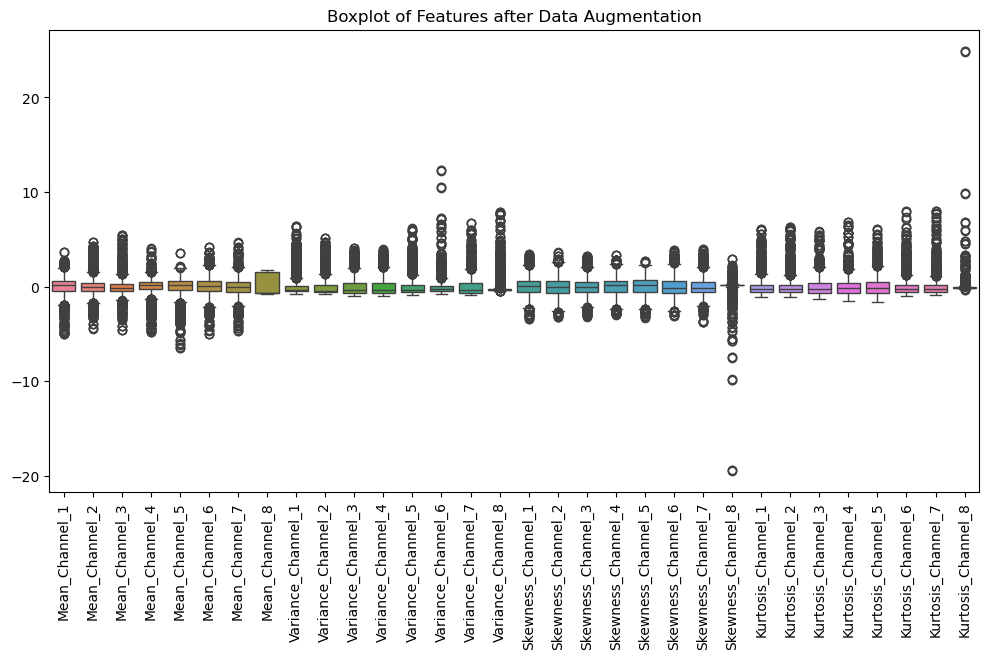

In [39]:
# Verify the length of the augmented data and target column
if len(df_augmented_full) == len(target_col) * 3:
    # Replicate the Target column for the augmented dataset
    target_col_augmented = pd.concat([target_col] * 3, ignore_index=True)

    # Add the 'Target' column back to the augmented dataset
    df_augmented_full['Target'] = target_col_augmented
else:
    print(f"Warning: Mismatch in number of rows between data and target. Data rows: {len(df_augmented_full)}, Target rows: {len(target_col) * 3}")

# Visualize Boxplot After Data Augmentation
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_augmented_full[numeric_cols])
plt.xticks(rotation=90)
plt.title('Boxplot of Features after Data Augmentation')
plt.show()


In [40]:
# Saving the final augmented dataset to a CSV file
output_file_path = 'augmented_emg_dataset.csv'
df_augmented_full.to_csv(output_file_path, index=False)

print(f'Dataset saved as: {output_file_path}')

Dataset saved as: augmented_emg_dataset.csv


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from scipy.stats import zscore
from scipy.signal import welch

0    1
1    2
2    3
3    4
4    5
Name: Target, dtype: int64
Number of duplicate rows: 0
Missing values in each column:
Mean_Channel_1        0
Mean_Channel_2        0
Mean_Channel_3        0
Mean_Channel_4        0
Mean_Channel_5        0
Mean_Channel_6        0
Mean_Channel_7        0
Mean_Channel_8        0
Variance_Channel_1    0
Variance_Channel_2    0
Variance_Channel_3    0
Variance_Channel_4    0
Variance_Channel_5    0
Variance_Channel_6    0
Variance_Channel_7    0
Variance_Channel_8    0
Skewness_Channel_1    0
Skewness_Channel_2    0
Skewness_Channel_3    0
Skewness_Channel_4    0
Skewness_Channel_5    0
Skewness_Channel_6    0
Skewness_Channel_7    0
Skewness_Channel_8    0
Kurtosis_Channel_1    0
Kurtosis_Channel_2    0
Kurtosis_Channel_3    0
Kurtosis_Channel_4    0
Kurtosis_Channel_5    0
Kurtosis_Channel_6    0
Kurtosis_Channel_7    0
Kurtosis_Channel_8    0
Target                0
dtype: int64
Target distribution after SMOTE:
Target
1    158
3    158
4    158
5    15

/home/tipu/.local/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:1961: UserWarning: nperseg = 256 is greater than input length  = 32, using nperseg = 32
  warnings.warn('nperseg = {0:d} is greater than input length '


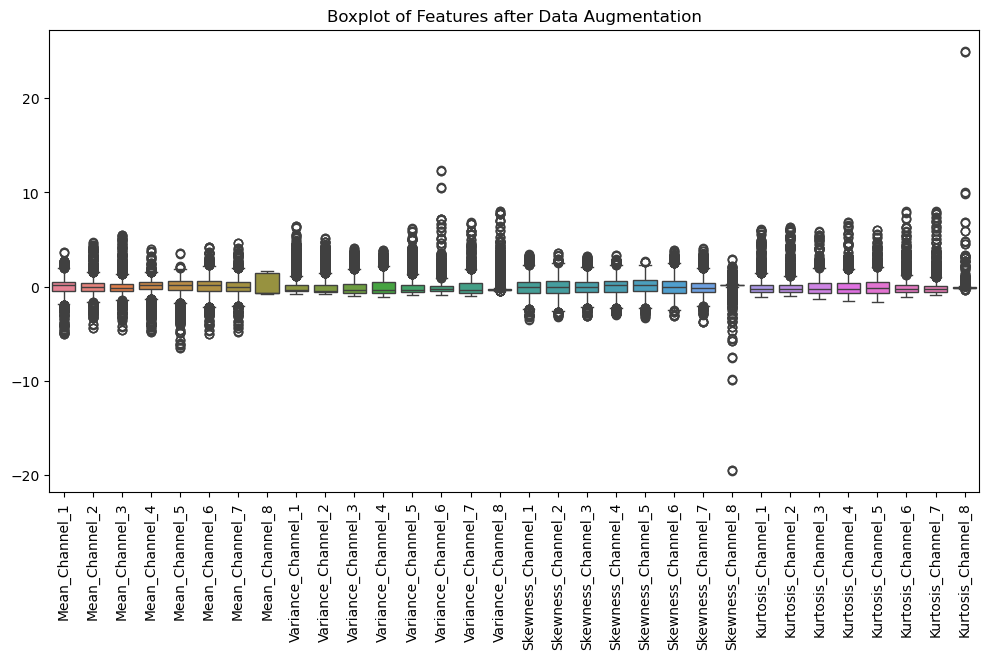

In [1]:

# Step 1: Ensure the 'Target' column is treated as string
df['Target'] = df['Target'].astype(str)

# Step 2: Remove everything except the 'G' part and extract the number
df['Target'] = df['Target'].str.extract(r'G(\d)').astype(int)

# Verify the cleaned target column
print(df['Target'].head())

# Check for duplicates and missing values
duplicates = df.duplicated().sum()
print(f'Number of duplicate rows: {duplicates}')
missing_values = df.isnull().sum()
print(f'Missing values in each column:\n{missing_values}')

# Drop duplicates
df_no_duplicates = df.drop_duplicates()

# Step 1: Calculate the Z-scores of the features to detect outliers
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()  # Select only numeric columns
numeric_cols.remove('Target')  # Remove 'Target' column from numeric columns
df_zscores = df[numeric_cols].apply(zscore)  # Calculate Z-scores for all numeric columns

# Step 2: Identify rows where the Z-score is above a threshold (e.g., 3 standard deviations)
outliers = (df_zscores.abs() > 3).any(axis=1)  # Identify outliers based on Z-scores
df_no_outliers = df[~outliers]

# Separate the Target column before normalization
target_col = df_no_outliers['Target'].copy()

# Step 3: Normalize the features (Z-score normalization), excluding the 'Target' column
scaler = StandardScaler()
df_normalized = df_no_outliers.copy()  # Using the dataset without outliers
df_normalized[numeric_cols] = scaler.fit_transform(df_no_outliers[numeric_cols])

# Feature Engineering
# RMS (Root Mean Square)
df_normalized['RMS'] = np.sqrt(np.mean(df_no_outliers[numeric_cols]**2, axis=1))

# MAV (Mean Absolute Value)
df_normalized['MAV'] = np.mean(np.abs(df_no_outliers[numeric_cols]), axis=1)

# SSC (Slope Sign Change)
def slope_sign_change(signal):
    return np.sum(np.diff(np.sign(np.diff(signal))) != 0)

df_normalized['SSC'] = df_no_outliers[numeric_cols].apply(slope_sign_change, axis=1)

# Power Spectral Density (PSD)
def compute_psd(signal):
    freqs, psd = welch(signal, fs=128)  # fs is the sampling frequency, adjust accordingly
    return np.sum(psd)

df_normalized['PSD'] = df_no_outliers[numeric_cols].apply(compute_psd, axis=1)

# Now let's apply SMOTE to oversample the minority class

# Step 1: Separate features and target
X = df_normalized[numeric_cols]
y = df_normalized['Target']

# Step 2: Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Combine resampled features and target into a new DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=numeric_cols)
df_resampled['Target'] = y_resampled

# Print the distribution of the target after SMOTE
print("Target distribution after SMOTE:")
print(df_resampled['Target'].value_counts())

# Data Augmentation
def add_noise(signal, noise_factor=0.05):
    noise = noise_factor * np.random.randn(len(signal))
    return signal + noise

# Apply noise to all numeric columns 3 times
augmented_dfs = [df_resampled.copy()]  # Include the SMOTE dataset as well
for _ in range(2):  # Two additional augmentations to make the dataset 3x larger
    df_temp = df_resampled.copy()
    df_temp[numeric_cols] = df_resampled[numeric_cols].apply(lambda col: add_noise(col))
    augmented_dfs.append(df_temp)

# Concatenate the original and augmented datasets
df_augmented_full = pd.concat(augmented_dfs, axis=0, ignore_index=True)

# Visualize Boxplot After Data Augmentation
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_augmented_full[numeric_cols])
plt.xticks(rotation=90)
plt.title('Boxplot of Features after Data Augmentation')
plt.show()


In [2]:
# Saving the final augmented dataset to a CSV file
output_file_path = 'augmented_emg_dataset.csv'
df_augmented_full.to_csv(output_file_path, index=False)

print(f'Dataset saved as: {output_file_path}')

Dataset saved as: augmented_emg_dataset.csv


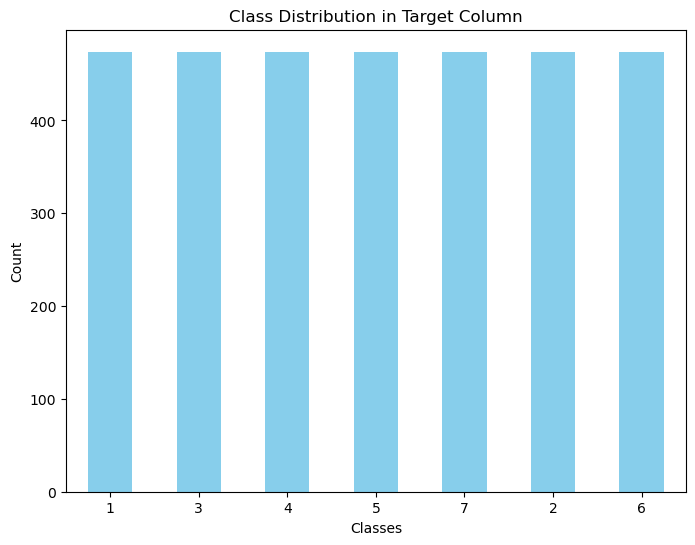

In [5]:
import matplotlib.pyplot as plt
import pandas as pd


# Load your dataset
data = pd.read_csv('augmented_emg_dataset.csv')


# Plot class distribution in the 'Target' column
class_counts = data['Target'].value_counts()

# Create the plot
plt.figure(figsize=(8,6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Class Distribution in Target Column')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [7]:
# Display the number of rows and columns in the dataset
print(f"Dataset size: {data.shape[0]} rows, {data.shape[1]} columns")


Dataset size: 3318 rows, 33 columns


In [8]:
# Display the number of rows and columns in the dataset
print(f"Dataset size: {df.shape[0]} rows, {df.shape[1]} columns")


Dataset size: 1344 rows, 33 columns
